## Introduction

This Jupyter Notebook is part of a scientific data analysis pipeline designed for processing and visualizing biomedical imaging data. It focuses on analyzing quantitative metrics extracted from microscope images, such as cell counts, tissue morphology measurements, and fluorescence intensity distributions. The notebook demonstrates how the reference dataset was constructed, providing transparency into the data generation process. However, it does not require users to run the dataset construction steps themselves. Instead, it provides a link to an annotated data object that users can directly explore. By combining interactive plots, summary statistics, and image overlays, this notebook enables scientists to correlate imaging-derived metrics with biological phenomena, providing deeper insights into tissue structure, cellular behavior, and disease progression. The goal is to streamline the analysis of complex biomedical datasets and facilitate hypothesis generation for further experimental studies.

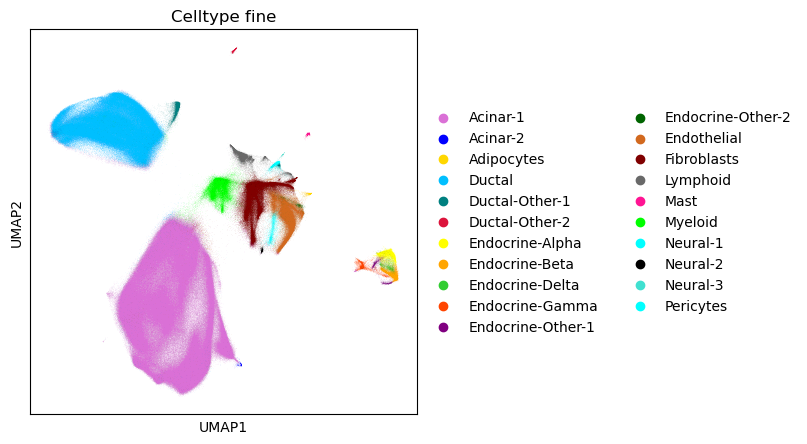

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import umap
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
import matplotlib.pyplot as plt

## Define datasets Lab IDs and paths to Xenium bundle directories downloaded from SenNet Data Sharing Portal

In [3]:
ids = ['JDC-WP-001-s', 'JDC-WP-001-c', 'JDC-WP-002-r', 'JDC-WP-002-c',
    'JDC-WP-003-ae', 'JDC-WP-003-d', 'JDC-WP-004-y', 'JDC-WP-004-c',
    'JDC-WP-005-n', 'JDC-WP-005-c', 'JDC-WP-007-o', 'JDC-WP-007-c',
    'JDC-WP-008-v', 'JDC-WP-008-b', 'JDC-WP-009-n', 'JDC-WP-009-c',
    'JDC-WP-010-w', 'JDC-WP-010-c', 'JDC-WP-011-b', 'JDC-WP-011-w',
    'JDC-WP-002-v', 'JDC-WP-012-ae', 'JDC-WP-012-c', 'JDC-WP-012-w',
    'JDC-WP-013-y', 'JDC-WP-013-b', 'JDC-WP-014-aj', 'JDC-WP-014-d']

# Define the paths to the Xenium bundle directories for each sample.
# samples_paths_dict = {'JDC-WP-001-s': ...}

## Load subset of cells from the datasets for each ID, filtering out low-quality cells.

The steps below were performed to generate the reference dataset.

In [ ]:
def load_xenium_dataset(id, path, N=None, suffix=None, f=1.):

    """Load a Xenium dataset from a specified Xenium bundle directory.

    Parameters
    ----------
    id : str
        Identifier for the sample (not used internally).
    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet' and 'cell_feature_matrix.h5' files.
    N : int, optional
        Number of cells to randomly sample. If None, use all cells.
    suffix : str, optional
        Suffix to append to cell indices.
    f : float, optional
        Scaling factor for spatial coordinates (default is 1.0).

    Returns
    -------
    adata : AnnData
        Data object with spatial coordinates in `adata.obsm['spatial']`.
    """

    obs = pd.read_parquet(path + '/cells.parquet', engine='auto', columns=None,
                          storage_options=None, use_nullable_dtypes=False).set_index('cell_id')
    adata = sc.read_10x_h5(path + '/cell_feature_matrix.h5')
    if not N is None:
        adata = adata[adata.obs.sample(N).index]
    adata.obs = obs.loc[adata.obs.index]
    if not suffix is None:
        adata.obs.index = adata.obs.index + suffix
    adata.obsm['spatial'] = (adata.obs[['x_centroid', 'y_centroid']]*f).astype(int).values

    return adata

# Set random seed for reproducibility
np.random.seed(0)

# Load 50000 cells for each of the 28 datasets, cncatenate them, and add a 'sample' column.
adata = sc.concat([load_xenium_dataset(id, dataPath + samples_paths_dict[id], N=50000, suffix='.' + id) for id in ids])
adata.obs['sample'] = pd.Series(adata.obs.index).str.split('.', expand=True)[1].astype('category').values

# Filter cells by counts of expressed genes
se_counts = adata.to_df().sum(axis=1)
keep_min_counts = se_counts[se_counts>=20].index

# Filter cells by number of expressed genes
se_genes = pd.Series(index=adata.obs.index, data=np.array((adata.X>0).sum(axis=1))[:, 0])
keep_min_genes = se_genes[se_genes>=3].index

cells_to_keep = keep_min_genes.intersection(keep_min_counts).sort_values()
adata = adata[cells_to_keep]
print(adata.shape)

# Log-transform the data
sc.pp.log1p(adata)

In [ ]:
# Prepare the PCA transformer and save it to a file, for later use with all cells of each dataset.
pca_transformer_xenium = PCA().fit(adata.X)
xgenes = adata.var.index.values.tolist()
adata.obsm['X_pca'] = pca_transformer_xenium.transform(adata[:, xgenes].X)
with open('PCA-v2-transformer-Xenium-subset.pklz', 'wb') as tempfile:
    pickle.dump((xgenes, pca_transformer_xenium), tempfile)

In [ ]:
# Perform UMAP on the PCA-reduced data and save the transformer to a file for later use with all cells of each dataset.
umap_transformer_xenium = umap.UMAP(n_neighbors=20, metric='correlation', min_dist=0.10, spread=1.0, n_jobs=4)
umap_transformer_xenium.fit(adata.obsm['X_pca'])
adata.obsm['X_umap'] = pd.DataFrame(index=adata.obs.index, data=umap_transformer_xenium.embedding_).reindex(adata.obs.index).fillna(20.).values
with open('UMAP-v2-transformer-Xenium-subset.pklz', 'wb') as tempfile:
    pickle.dump(umap_transformer_xenium, tempfile)

In [ ]:
# Compute K-nearest neighbors graph and Leiden clustering
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X_pca', metric='correlation')
sc.tl.leiden(adata, key_added='cluster', resolution=1.0)

# Explore the annotated reference dataset

We annotated the reference dataset using the Leiden clustering algorithm, which is a community detection method that identifies clusters in large networks.
The clusters were determined based on the K-nearest neighbors graph constructed from the PCA-reduced data.

To get started, download the dataset (~3 GB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent cells to visualize 
and explore the multimodal imaging data.

In [ ]:
!curl -L "https://zenodo.org/api/records/15777497/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [4]:
dataPath = './'

adata = sc.read_h5ad(dataPath + 'x-subset-50k-all-umap-annotated.h5ad')

In [5]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata, color='Celltype fine', s=0.1)

In [13]:
fig, ax = plt.subplots(1,1,figsize=(7, 1.5))
ax = adata.obs['Celltype fine'].value_counts().plot.bar()
for container in ax.containers:
    ax.bar_label(container, rotation=90, fontsize=6, padding=3)
plt.show()

In [14]:
sc.pl.umap(adata, color='Age group', s=1)

# Subset endocrine celltype 

In [53]:
adata_sub = adata[adata.obs['Celltype fine'].isin(['Endocrine-Alpha', 
                                                  'Endocrine-Beta', 
                                                  'Endocrine-Gamma',
                                                  'Endocrine-Delta',
                                                  'Endocrine-Other-1',
                                                  'Endocrine-Other-2'])].copy()

sc.tl.umap(adata_sub, min_dist=0.1, spread=1.0, n_components=2, random_state=0)

plt.rcParams["figure.figsize"] = (4, 4)
q = 0.001
wh = ((se1:=pd.DataFrame(adata_sub.obsm['X_umap'])[0])>=se1.quantile(q)) & (se1<se1.quantile(1-q)) &\
     ((se2:=pd.DataFrame(adata_sub.obsm['X_umap'])[1])>=se2.quantile(q)) & (se2<se2.quantile(1-q))
sc.pl.umap(adata_sub[wh], color=['Celltype fine'], s=3)

# Celltype average expression of markers

In [ ]:
def showChunkedMakerDotPlots(adata, identity='Celltype fine', th=0.8,
                            show_chunked=True):

    """Display dot plots for clusters of genes based on hierarchical clustering of annotated data.

    Parameters
    ----------
    adata : AnnData
        Annotated data object containing gene expression data.

    identity : str, optional
        Column name in `adata.obs` to group by for clustering (default is 'Celltype fine').

    th : float, optional
        Distance threshold for clustering (default is 0.8).

    show_chunked : bool, optional
        If True, display dot plots for each cluster of genes separately (default is True).
        Otherwise, display a single (very wide) dot plot for all genes in the dataset.
    """    

    df = adata.to_df()
    df.index = adata.obs[identity].values
    df = df.groupby(level=0, observed=False).mean()
    Z = linkage(pdist(df.values.T, metric='correlation'),
                method='average', optimal_ordering=True)

    plt.rcParams["figure.figsize"] = (5, 2)
    dclusters = fcluster(Z, t=th, criterion='distance')
    udclusters = sorted(np.unique(dclusters))
    print(f'Distance threshold: {th}, number of clusters: {len(udclusters)}')

    D = dendrogram(Z, color_threshold=th, above_threshold_color='lightgrey', no_labels=True)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    plt.show()

    indices = np.array(dendrogram(Z, no_plot=True)['leaves'])
    all_markers = adata.var.index[indices]

    sc.tl.dendrogram(adata, groupby=identity, use_rep='X_pca', linkage_method='average')

    nItems = len(adata.obs[identity].unique())

    if show_chunked:
        # Display the dotplot for each cluster of genes separately.
        for cl in udclusters:
            subset_markers = all_markers[dclusters[D['leaves']]==cl]
            sc.pl.dotplot(adata, subset_markers, groupby=identity,
                        dendrogram=True, standard_scale='var',
                        figsize=(4. + len(subset_markers) * 0.25, 1. + nItems * 0.25))
    else:
        # Plot the dotplot with dendrogram of all genes in the dataset.
        # This is computationally expensive and hard to navigate.
        sc.pl.dotplot(adata, all_markers, groupby=identity,
                    dendrogram=True, standard_scale='var')
    return

In [44]:
showChunkedMakerDotPlots(adata)

# Explore markers via violin plots

In [ ]:
plt.rcParams["figure.figsize"] = (5, 2.5)
sc.pl.violin(adata, keys=['PPY', 'GCG'], groupby='Celltype fine', rotation=90)
sc.pl.violin(adata, keys=['AMY2A', 'RBPJL'], groupby='Celltype fine', rotation=90)
sc.pl.violin(adata, keys=['LGI4', 'L1CAM'], groupby='Celltype fine', rotation=90)
sc.pl.violin(adata, keys=['CTRB1', 'SPINT2'], groupby='Celltype fine', rotation=90)
sc.pl.violin(adata, keys=['ADIPOQ', 'VEGFA'], groupby='Celltype fine', rotation=90)